<font size = 32> Juvo test </font>

# Import libraries

In [1]:
############################################### Run this at first time###############################################
# !pip install imbalanced-learn==0.9.0
# !pip install scikit-learn==1.0.2
# !pip install numpy==1.19.5
# !pip install xgboost==1.6.1
# !pip install pandas==1.3.2
# !pip install matplotlib==3.3.3
# !pip install seaborn==0.11.1

In [102]:
#Data manipulation libs
import pandas as pd
import numpy as np

#Machine Learning libs
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score,precision_score,recall_score,roc_auc_score
import imblearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

#Aux libs
from functools import reduce

pd.options.display.max_columns = None

%reload_ext watermark
%watermark --iversions

matplotlib: 3.3.3
seaborn   : 0.11.1
imblearn  : 0.9.0
xgboost   : 1.6.1
sklearn   : 1.0.2
numpy     : 1.19.5
pandas    : 1.3.2



# Functions

In [3]:
def variable_summary(series: pd.Series):
    """
    Series describer
    
    Parameters
    ----------
    :series: pandas Series to analyse 
    """
    variable = series.name
    dtype = series.dtype
    na = series.isna().sum()
    na_pct = str(round(100*na/series.shape[0],2))+"%"
    if('object' in str(dtype)):
        first_element = series.pipe(lambda x: x[x==x])
        if(first_element.shape[0] == 0):
            unique = series.nunique()
        else:
            element_type = str(type(first_element.iloc[0]))
            if((element_type == "<class 'numpy.ndarray'>") | (element_type == "<class 'list'>") | (element_type == "<class 'set'>") | (element_type == "<class 'dict'>")):
                unique = '-'
            else:
                unique = series.nunique()
    else:
        unique = series.nunique()
    
    
    if( ('object' in str(dtype)) | ('category' in str(dtype)) ):
        minimum,mean,maximum,std,quat25,quat75,median,skew,kurt,mean_std = ("-","-","-","-","-","-","-","-","-","-")
    else:
        minimum = series.min()
        mean = series.mean()
        maximum = series.max()
        std = series.std()
        if('bool' in str(dtype)):
            quat25 = series.astype(float).quantile(0.25)
            quat75 = series.astype(float).quantile(0.75)
            median = series.astype(float).quantile(0.5)
        else:
            quat25 = series.quantile(0.25)
            quat75 = series.quantile(0.75)
            median = series.quantile(0.5)
        
        if( ('int' in str(dtype)) | ('float' in str(dtype)) ):
            skew = round(series.skew(),2) #skewness
            kurt = round(series.kurt(),2) #kurtosis
            if((all(series == 0)) or (std == 0)):
                mean_std = 0
            else:
                mean_std = round(mean/std,2)
        else:
            skew,kurt,mean_std = ("-","-","-")
        
        
    return(pd.DataFrame({'variable':[variable],
                        'type':[dtype],
                        'na':[na],
                        'na_pct':[na_pct],
                        'unique':[unique],
                        'min':[minimum],
                        'quat25':[quat25],
                        'median':[median],
                        'mean':[mean],
                        'quat75':[quat75],
                        'max':[maximum],
                        'std':[std],
                        'skewness':[skew],
                        'kurtosis':[kurt],
                        'media_desvio':[mean_std]}))

#Data describer function
def describe(df):
    """
    Dataframe describer
    
    Parameters
    ----------
    :df: pandas DataFrame to analyse 
    """
    print("Number of Rows:",df.shape[0])
    describe_dataset = reduce(lambda x,y: pd.concat((x,y)), [variable_summary(df[col]) for col in df.columns])
    return describe_dataset.reset_index(drop=True)


# Import data

In [4]:
loans = pd.read_csv("../data/Brazil_DS_loans_2019-11-10_2019-12-05.csv")
prev  = pd.read_csv("../data/Brazil_DS_prev_loans.csv")
recharge = pd.read_csv("../data/Brazil_DS_recharges_2019-08-10_2019-12-05.csv")

In [5]:
#Convert into datetime
prev.created_at = pd.to_datetime(prev.created_at)
loans.created_at = pd.to_datetime(loans.created_at)
recharge.recharge_timestamp = pd.to_datetime(recharge.recharge_timestamp)

In [6]:
#Loans description
#There are only 2 different loan amount
#On this one, only 18.89%% did not paided
describe(loans)

Number of Rows: 12926


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,9513,-,-,-,-,-,-,-,-,-,-
1,loan_id,int64,0,0.0%,12926,16513,19745.25,22986.5,22984.485842,26218.75,29454,3736.246948,-0.0,-1.2,6.15
2,amount,float64,0,0.0%,2,5.0,5.0,5.0,5.449095,5.0,10.0,1.429666,2.87,6.24,3.81
3,created_at,datetime64[ns],0,0.0%,12926,2019-11-10 00:04:42.327443,2019-11-18 00:32:10.321530624,2019-11-24 13:47:35.415590400,2019-11-23 19:56:40.806889472,2019-11-29 15:08:45.370689024,2019-12-04 23:54:57.280521,6 days 22:38:10.394918360,-,-,-
4,paid_at,object,2442,18.89%,10484,-,-,-,-,-,-,-,-,-,-


In [7]:
#Prev description
#There are only 4 different loan amount
#On this one, only 0.58% did not paided
#less users than loans dataset
describe(prev)

Number of Rows: 6035


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,1964,-,-,-,-,-,-,-,-,-,-
1,loan_id,int64,0,0.0%,6035,1,6669.0,10455.0,9932.314499,13641.5,16504,4315.519482,-0.37,-0.89,2.3
2,amount,float64,0,0.0%,4,3.85,5.0,5.0,5.77029,5.0,10.0,1.805531,1.92,1.67,3.2
3,created_at,datetime64[ns],0,0.0%,6035,2019-01-16 23:41:24.785649,2019-09-20 13:26:54.973658112,2019-10-12 09:15:09.591973888,2019-10-04 06:41:34.816445696,2019-10-28 16:23:30.478653440,2019-11-09 23:07:27.962833,32 days 11:29:48.450471939,-,-,-
4,paid_at,object,35,0.58%,6000,-,-,-,-,-,-,-,-,-,-


In [8]:
#recharge description
describe(recharge)

Number of Rows: 94793


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,9431,-,-,-,-,-,-,-,-,-,-
1,recharge_timestamp,datetime64[ns],0,0.0%,94058,2019-08-10 00:04:21,2019-09-19 21:42:41,2019-10-23 11:31:45,2019-10-17 19:35:46.300845312,2019-11-16 15:59:02,2019-12-04 23:53:01,33 days 22:34:54.137257993,-,-,-
2,recharge_value,float64,0,0.0%,15,3.0,5.0,10.0,11.328081,15.0,100.0,6.757032,1.7,6.07,1.68
3,balance_after_recharge,float64,52,0.05%,3175,0.0,6.07,10.27,12.432254,15.65,264.44,7.862897,4.54,83.96,1.58
4,institution_name,object,35412,37.36%,114,-,-,-,-,-,-,-,-,-,-
5,institution_type,object,35804,37.77%,9,-,-,-,-,-,-,-,-,-,-


# Data analysis

According to the explanation: "_A loan is considered repaid if it's paid within 60 days_".<br> 
Besides, "_a user pays for loans by making recharges after taking a loan_"<br>
Let's see this behaviour taking a user

In [9]:
prev.query("paid_at != paid_at").head(10)

,uuid,loan_id,amount,created_at,paid_at
116,fa19674e1eb344f8b19591c493a4557b,1371,5.0,2019-07-12 09:37:46.031214,NaN
483,a66c6e2d6b6540c6b2f6a136def16cd1,1269,5.0,2019-07-10 02:15:15.857633,NaN
574,1e449a1ac95a49c3b8353dd05749d78d,2426,5.0,2019-08-02 23:39:21.905010,NaN
621,1dd011320a994ef7a4453f5745d7ce4f,1487,5.0,2019-07-14 22:01:48.230560,NaN
912,67b98f4c0c66470198a2f7bd179b3b97,648,5.0,2019-06-25 13:55:48.236896,NaN
1155,4f73292fb7864e41a9853967789e64b3,936,5.0,2019-07-02 12:42:29.478425,NaN
1182,d72c0910dba4436fa420df0a59adeb1a,2688,5.0,2019-08-07 21:22:52.958146,NaN
1559,56c089f373fc4f7bb46c5e56f11edaa1,382,5.0,2019-06-15 01:18:59.349732,NaN
1605,95f77a808cf240339a4c7bfbe903970d,622,5.0,2019-06-24 18:58:18.449026,NaN
1809,9f58366573394e4587675d5cd7188adc,726,5.0,2019-06-27 12:41:36.313722,NaN


In this following example, even after the user recharging the loan 1371, the time between the loan and the first recharge is over 60 days, so the loan is considered not paid. However, considering the loan 23811, the payment occured a few days after that

In [10]:
uuid = 'fa19674e1eb344f8b19591c493a4557b'
pd.concat((prev.query("'%s' == uuid"%uuid).assign(DF='prev'),
           loans.query("'%s' == uuid"%uuid).assign(DF = 'loans'))).sort_values('created_at')

,uuid,loan_id,amount,created_at,paid_at,DF
116,fa19674e1eb344f8b19591c493a4557b,1371,5.0,2019-07-12 09:37:46.031214,NaN,prev
5221,fa19674e1eb344f8b19591c493a4557b,23811,5.0,2019-11-26 04:09:43.098861,2019-11-30 01:04:05.827473,loans


In [11]:
recharge.query("'%s' == uuid"%uuid).sort_values("recharge_timestamp")

,uuid,recharge_timestamp,recharge_value,balance_after_recharge,institution_name,institution_type
38027,fa19674e1eb344f8b19591c493a4557b,2019-10-14 23:23:29,10.0,10.09,M4U URA-USSD,Distribuidor Nacional
80222,fa19674e1eb344f8b19591c493a4557b,2019-11-26 01:09:43,5.0,5.10,NaN,NaN
83980,fa19674e1eb344f8b19591c493a4557b,2019-11-29 22:03:29,13.0,14.12,M4U URA-USSD,Distribuidor Nacional


Are the institution name and type always the same, taking the same uuid?

In [12]:
#No
def nunique(x):
    return x.nunique()
recharge[['institution_name','institution_type','uuid']].drop_duplicates().groupby("uuid").agg({"institution_name":nunique,"institution_type":nunique})

,institution_name,institution_type
uuid,,
000c20ae97084d4199e1c61a6a15a79e,0,0
000c4c43634a4e4cabee82c946481adc,4,2
00163f5a2e75448daf00186d60ce5ce7,2,2
00186a872c254b5fbd8be83f5343efec,1,1
001d161dd9854887b7d38e5f40db36c9,4,2
...,...,...
ffd5de5cc31e4627bad4db3bb86729e0,3,3
ffd62186c39c45d785b5fe15e0a79b11,5,3
ffd8a8416e824e4289e4f5d4cc69f8de,5,2


Is the balance after recharge always bigger or equal than the recharge itself?

In [13]:
#No
((recharge['balance_after_recharge']-recharge['recharge_value']) <0).sum()

17

In [14]:
recharge.assign(test = lambda x: x['balance_after_recharge'] - x['recharge_value']).query('test < 0')

,uuid,recharge_timestamp,recharge_value,balance_after_recharge,institution_name,institution_type,test
5530,d1785a6bfa5e446995425a9338009bad,2019-08-22 09:42:53,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
12251,aab4e319955744cd8367adb945733c77,2019-08-27 09:59:24,49.99,0.04,M4U Venda Direta 3,Venda Direta,-49.95
15293,82b377f9615049fc9cf6bd08a32016a5,2019-09-09 09:50:14,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
15494,302496aab95040feba336208d483db5e,2019-09-09 09:50:37,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
15994,34d45fa905754e7eb51abf375858b7ed,2019-09-08 09:30:30,31.49,0.30,M4U Venda Direta,Venda Direta,-31.19
22504,d1785a6bfa5e446995425a9338009bad,2019-09-22 09:33:46,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
28207,aab4e319955744cd8367adb945733c77,2019-09-27 10:19:54,49.99,0.04,M4U Venda Direta 3,Venda Direta,-49.95
34954,34d45fa905754e7eb51abf375858b7ed,2019-10-08 09:25:57,31.49,13.91,M4U Venda Direta,Venda Direta,-17.58
37873,302496aab95040feba336208d483db5e,2019-10-09 11:37:50,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
39743,f43f85b04cdb4ced9c10f94b0ca2f763,2019-10-16 18:57:57,49.89,0.00,M4U Venda Direta 3,Venda Direta,-49.89


Let's take an example

In [15]:
loan_ = pd.concat((prev,loans))

In [16]:
loan_.query("uuid == '302496aab95040feba336208d483db5e'")

,uuid,loan_id,amount,created_at,paid_at
11710,302496aab95040feba336208d483db5e,22496,5.0,2019-11-23 10:31:28.434921,2019-12-07 19:51:53.315303


Let's create a single dataset, with the data history

In [17]:
df = pd.concat((loan_,recharge.rename(columns = {"recharge_timestamp":"created_at","recharge_value":"amount"})))\
    .sort_values(["uuid","created_at"]).reset_index(drop=True)

In [18]:
#If loan_id is NULL, than it is a recharge. Otherwise, it is a loan
df.query("'7faa3668919145fdbb703ab80bdd60ff' == uuid")

,uuid,loan_id,amount,created_at,paid_at,balance_after_recharge,institution_name,institution_type
55494,7faa3668919145fdbb703ab80bdd60ff,NaN,5.0,2019-11-12 12:38:31.000000,NaN,5.01,NaN,NaN
55495,7faa3668919145fdbb703ab80bdd60ff,17169.0,5.0,2019-11-12 15:38:30.448831,NaN,NaN,NaN,NaN


In [19]:
describe(df)

Number of Rows: 113754


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,9513,-,-,-,-,-,-,-,-,-,-
1,loan_id,float64,94793,83.33%,18961,1.0,14068.0,19959.0,18830.176784,24710.0,29454.0,7239.446855,-0.59,-0.52,2.6
2,amount,float64,0,0.0%,17,3.0,5.0,10.0,10.365187,15.0,100.0,6.56439,1.86,6.58,1.58
3,created_at,datetime64[ns],0,0.0%,113019,2019-01-16 23:41:24.785649,2019-09-24 14:57:04,2019-10-29 17:25:13.500000,2019-10-21 07:18:11.359803392,2019-11-20 06:00:47.915520,2019-12-04 23:54:57.280521,34 days 06:33:11.679607582,-,-,-
4,paid_at,object,97270,85.51%,16484,-,-,-,-,-,-,-,-,-,-
5,balance_after_recharge,float64,19013,16.71%,3175,0.0,6.07,10.27,12.432254,15.65,264.44,7.862897,4.54,83.96,1.58
6,institution_name,object,54373,47.8%,114,-,-,-,-,-,-,-,-,-,-
7,institution_type,object,54765,48.14%,9,-,-,-,-,-,-,-,-,-,-


Some feature we should create:
* loan amount until now
* recharge amount until now
* recharge count until now
* loan count until now
* not paid loan amount until now
* days since the last not paid loan
* days since the last recharge
* days since the last loan
* last instituition type
* most commum instituition type
* balance_after_recharge - recharge mean since the last loan

# ABT

In [20]:
df=df.assign(current_loan = lambda x: x.groupby("uuid").loan_id.transform(lambda y: y.fillna(method='ffill')),
             description = lambda x: np.where(x["loan_id"] == x["loan_id"],'loan','recharge'))

Creating the new features

In [32]:
#loan amount until now
df["loan_amount_cumsum"] = df.assign(loan_amount = lambda x: np.where(x["description"] == 'loan',x['amount'],0))\
                             .groupby('uuid').loan_amount.transform(lambda x: x.cumsum())

#recharge amount until now
df["recharge_amount_cumsum"] = df.assign(recharge_amount = lambda x: np.where(x["description"] == 'recharge',x['amount'],0))\
                             .groupby('uuid').recharge_amount.transform(lambda x: x.cumsum())

#loan count until now
df["loan_cumcount"] = df.assign(loan_times = lambda x: np.where(x["description"] == 'loan',1,0))\
                             .groupby('uuid').loan_times.transform(lambda x: x.cumsum())
#recharge count until now
df["recharge_cumcount"] = df.assign(recharge_times = lambda x: np.where(x["description"] == 'recharge',1,0))\
                             .groupby('uuid').recharge_times.transform(lambda x: x.cumsum())

#not paid loan amount until now
df["not_paid_loan_cumsum"] = df.assign(not_paid_loan = lambda x: np.where((x["description"] == 'loan') &
                                                                            (x['paid_at']!=x['paid_at']) ,x['amount'],0))\
                             .groupby('uuid').not_paid_loan.transform(lambda x: x.cumsum())

#target feature for classification
df["target"] = np.where(df["paid_at"] == df["paid_at"],0,1)

#days since the last not paid loan
df["days_after_last_no_paid"] = (df["created_at"] - df.join(df.groupby("uuid")\
          .apply(lambda y: np.where(y["target"] == 1,
                                    y["created_at"],
                                    np.datetime64("NaT"))).explode().reset_index().rename(columns={0:"last_no_paid_day"}).drop(columns="uuid"))\
          .groupby("uuid").last_no_paid_day.transform(lambda x: x.fillna(method = 'ffill')))/np.timedelta64(1,"D")

#days since the last recharge
df["days_after_last_recharge"] = (df["created_at"] - df.join(df.groupby("uuid")\
          .apply(lambda y: np.where(y["description"] == 'recharge',
                                    y["created_at"],
                                    np.datetime64("NaT"))).explode().reset_index().rename(columns={0:"last_recharge"}).drop(columns="uuid"))\
          .groupby("uuid").last_recharge.transform(lambda x: x.fillna(method = 'ffill')))/np.timedelta64(1,"D")

#days since the last loan
df = df.merge(df.query("description == 'loan'")\
  .pipe(lambda x: x.join(x.groupby("uuid").created_at.transform(lambda x: x.shift(1)).rename("last_loan")))\
  .assign(days_after_last_loan = lambda x: (x["created_at"] - x["last_loan"])/np.timedelta64(1,"D"))\
  [["uuid","loan_id","days_after_last_loan"]],
        how ='left',
        on = ["uuid","loan_id"])

#most commum instituition type
df = df.merge(df.groupby(["uuid",'institution_type']).amount.count().sort_values(ascending=False).reset_index()\
           .rename(columns = {"institution_type":"most_commum_institution_type"})\
           .groupby("uuid").most_commum_institution_type.first().reset_index(),
        on = 'uuid',
         how = 'left')

#last instituition type
df["last_intitution_type"] = df.groupby("uuid").institution_type.transform(lambda x: x.fillna(method="ffill"))

#balance_after_recharge - recharge mean since the last loan
df = df.merge(df.assign(loan_id_aux = lambda x: x.groupby("uuid").loan_id.transform(lambda y:y.fillna(method="bfill")))\
  .assign(loan_id_aux = lambda x: np.where(x["loan_id"] == x["loan_id_aux"],np.nan,x["loan_id_aux"]))\
  .groupby(["uuid","loan_id_aux"]).apply(lambda x: (x["balance_after_recharge"]-x["amount"]).mean()).reset_index()\
  .rename(columns = {"loan_id_aux":"loan_id",0:"diff_balance_recharge"}),
        on = ["uuid","loan_id"],
        how = "left")

In [120]:
df.assign(no_paid = lambda x: np.where((x["paid_at"] != x["paid_at"]) & (x["loan_id"]==x["loan_id"]),
                                       x["created_at"],
                                       np.datetime64("NaT")))\
  .assign(no_paid = lambda x: x["no_paid"].shift(1))\
  .assign(no_paid = lambda x: x["no_paid"].fillna(method="ffill"))\
  .assign(days_after_last_no_paid = lambda x: (x.created_at - x.no_paid)/np.timedelta64(1,"D"))\
    .query("uuid == 'e6504b30a1c844eeb3bd3fd9a2d4c2a3'")

,uuid,loan_id,amount,created_at,paid_at,balance_after_recharge,institution_name,institution_type,current_loan,description,loan_amount_cumsum,recharge_amount_cumsum,loan_cumcount,recharge_cumcount,not_paid_loan_cumsum,target,days_after_last_no_paid,days_after_last_recharge,days_after_last_loan,most_commum_institution_type,last_intitution_type,diff_balance_recharge,no_paid
101224,e6504b30a1c844eeb3bd3fd9a2d4c2a3,1.0,3.85,2019-01-16 23:41:24.785649,NaN,NaN,NaN,NaN,1.0,loan,3.85,0.0,1,0,3.85,1,-299.646890,NaN,NaN,Distribuidor Nacional,NaN,NaN,2019-11-12 15:12:56.082602
101225,e6504b30a1c844eeb3bd3fd9a2d4c2a3,2.0,4.85,2019-01-16 23:41:59.417087,NaN,NaN,NaN,NaN,2.0,loan,8.70,0.0,2,0,8.70,1,0.000401,NaN,0.000401,Distribuidor Nacional,NaN,NaN,2019-01-16 23:41:24.785649
101226,e6504b30a1c844eeb3bd3fd9a2d4c2a3,3.0,5.00,2019-01-16 23:43:16.427969,NaN,NaN,NaN,NaN,3.0,loan,13.70,0.0,3,0,13.70,1,0.000891,NaN,0.000891,Distribuidor Nacional,NaN,NaN,2019-01-16 23:41:59.417087
101227,e6504b30a1c844eeb3bd3fd9a2d4c2a3,104.0,5.00,2019-04-30 14:08:32.977881,2019-05-29 14:39:54.016985,NaN,NaN,NaN,104.0,loan,18.70,0.0,4,0,13.70,0,103.600886,NaN,103.600886,Distribuidor Nacional,NaN,NaN,2019-01-16 23:43:16.427969
101228,e6504b30a1c844eeb3bd3fd9a2d4c2a3,2305.0,5.00,2019-07-31 15:20:09.776068,2019-08-30 22:33:59.344821,NaN,NaN,NaN,2305.0,loan,23.70,0.0,5,0,13.70,0,195.650617,NaN,92.049731,Distribuidor Nacional,NaN,NaN,2019-01-16 23:43:16.427969
101229,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,15.00,2019-08-30 19:32:37.000000,NaN,15.16,Itau,Banco,2305.0,recharge,23.70,15.0,5,1,13.70,1,225.825933,0.000000,NaN,Distribuidor Nacional,Banco,NaN,2019-01-16 23:43:16.427969
101230,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,5.00,2019-09-26 14:31:24.000000,NaN,5.19,NaN,NaN,2305.0,recharge,23.70,20.0,5,2,13.70,1,252.616754,0.000000,NaN,Distribuidor Nacional,Banco,NaN,2019-01-16 23:43:16.427969
101231,e6504b30a1c844eeb3bd3fd9a2d4c2a3,7659.0,5.00,2019-09-26 17:31:22.789939,2019-10-10 18:07:25.654335,NaN,NaN,NaN,7659.0,loan,28.70,20.0,6,2,13.70,0,252.741740,0.124986,57.091123,Distribuidor Nacional,Banco,0.175000,2019-01-16 23:43:16.427969
101232,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,13.00,2019-10-10 15:06:51.000000,NaN,13.21,Recarga Pay,Distribuidor Nacional,7659.0,recharge,28.70,33.0,6,3,13.70,1,266.641372,0.000000,NaN,Distribuidor Nacional,Distribuidor Nacional,NaN,2019-01-16 23:43:16.427969
101233,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,10.00,2019-11-06 17:13:02.000000,NaN,10.23,Recarga Pay,Distribuidor Nacional,7659.0,recharge,28.70,43.0,6,4,13.70,1,293.729000,0.000000,NaN,Distribuidor Nacional,Distribuidor Nacional,NaN,2019-01-16 23:43:16.427969


In [103]:
#Test case
df.query("uuid == 'e6504b30a1c844eeb3bd3fd9a2d4c2a3'")

,uuid,loan_id,amount,created_at,paid_at,balance_after_recharge,institution_name,institution_type,current_loan,description,loan_amount_cumsum,recharge_amount_cumsum,loan_cumcount,recharge_cumcount,not_paid_loan_cumsum,target,days_after_last_no_paid,days_after_last_recharge,days_after_last_loan,most_commum_institution_type,last_intitution_type,diff_balance_recharge
101224,e6504b30a1c844eeb3bd3fd9a2d4c2a3,1.0,3.85,2019-01-16 23:41:24.785649,NaN,NaN,NaN,NaN,1.0,loan,3.85,0.0,1,0,3.85,1,0.000000,NaN,NaN,Distribuidor Nacional,NaN,NaN
101225,e6504b30a1c844eeb3bd3fd9a2d4c2a3,2.0,4.85,2019-01-16 23:41:59.417087,NaN,NaN,NaN,NaN,2.0,loan,8.70,0.0,2,0,8.70,1,0.000000,NaN,0.000401,Distribuidor Nacional,NaN,NaN
101226,e6504b30a1c844eeb3bd3fd9a2d4c2a3,3.0,5.00,2019-01-16 23:43:16.427969,NaN,NaN,NaN,NaN,3.0,loan,13.70,0.0,3,0,13.70,1,0.000000,NaN,0.000891,Distribuidor Nacional,NaN,NaN
101227,e6504b30a1c844eeb3bd3fd9a2d4c2a3,104.0,5.00,2019-04-30 14:08:32.977881,2019-05-29 14:39:54.016985,NaN,NaN,NaN,104.0,loan,18.70,0.0,4,0,13.70,0,103.600886,NaN,103.600886,Distribuidor Nacional,NaN,NaN
101228,e6504b30a1c844eeb3bd3fd9a2d4c2a3,2305.0,5.00,2019-07-31 15:20:09.776068,2019-08-30 22:33:59.344821,NaN,NaN,NaN,2305.0,loan,23.70,0.0,5,0,13.70,0,195.650617,NaN,92.049731,Distribuidor Nacional,NaN,NaN
101229,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,15.00,2019-08-30 19:32:37.000000,NaN,15.16,Itau,Banco,2305.0,recharge,23.70,15.0,5,1,13.70,1,0.000000,0.000000,NaN,Distribuidor Nacional,Banco,NaN
101230,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,5.00,2019-09-26 14:31:24.000000,NaN,5.19,NaN,NaN,2305.0,recharge,23.70,20.0,5,2,13.70,1,0.000000,0.000000,NaN,Distribuidor Nacional,Banco,NaN
101231,e6504b30a1c844eeb3bd3fd9a2d4c2a3,7659.0,5.00,2019-09-26 17:31:22.789939,2019-10-10 18:07:25.654335,NaN,NaN,NaN,7659.0,loan,28.70,20.0,6,2,13.70,0,0.124986,0.124986,57.091123,Distribuidor Nacional,Banco,0.175000
101232,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,13.00,2019-10-10 15:06:51.000000,NaN,13.21,Recarga Pay,Distribuidor Nacional,7659.0,recharge,28.70,33.0,6,3,13.70,1,0.000000,0.000000,NaN,Distribuidor Nacional,Distribuidor Nacional,NaN
101233,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,10.00,2019-11-06 17:13:02.000000,NaN,10.23,Recarga Pay,Distribuidor Nacional,7659.0,recharge,28.70,43.0,6,4,13.70,1,0.000000,0.000000,NaN,Distribuidor Nacional,Distribuidor Nacional,NaN


Removing recharges

In [34]:
df_ = df.query("description == 'loan'").drop(columns = 'description')

In [35]:
describe(df_)

Number of Rows: 18961


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,9513,-,-,-,-,-,-,-,-,-,-
1,loan_id,float64,0,0.0%,18961,1.0,14068.0,19959.0,18830.176784,24710.0,29454.0,7239.446855,-0.59,-0.52,2.6
2,amount,float64,0,0.0%,4,3.85,5.0,5.0,5.551326,5.0,10.0,1.566274,2.49,4.19,3.54
3,created_at,datetime64[ns],0,0.0%,18961,2019-01-16 23:41:24.785649,2019-10-30 12:19:01.683214080,2019-11-18 15:29:41.445861120,2019-11-07 17:47:05.939935232,2019-11-27 19:16:52.188889088,2019-12-04 23:54:57.280521,30 days 09:11:00.366475161,-,-,-
4,paid_at,object,2477,13.06%,16484,-,-,-,-,-,-,-,-,-,-
5,balance_after_recharge,float64,18961,100.0%,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,institution_name,object,18961,100.0%,0,-,-,-,-,-,-,-,-,-,-
7,institution_type,object,18961,100.0%,0,-,-,-,-,-,-,-,-,-,-
8,current_loan,float64,0,0.0%,18961,1.0,14068.0,19959.0,18830.176784,24710.0,29454.0,7239.446855,-0.59,-0.52,2.6
9,loan_amount_cumsum,float64,0,0.0%,62,3.85,5.0,5.0,15.494491,15.0,275.0,21.622183,4.14,24.16,0.72


Let's drop useless columns, like 100% missing values features, the id features, and the date feature

In [36]:
df_ = df_.drop(columns = ["balance_after_recharge","institution_name","institution_type",
                          "uuid","loan_id","current_loan",
                          "created_at","paid_at"])

In [38]:
describe(df_)

Number of Rows: 18961


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,amount,float64,0,0.0%,4,3.85,5.0,5.0,5.551326,5.0,10.0,1.566274,2.49,4.19,3.54
1,loan_amount_cumsum,float64,0,0.0%,62,3.85,5.0,5.0,15.494491,15.0,275.0,21.622183,4.14,24.16,0.72
2,recharge_amount_cumsum,float64,0,0.0%,645,0.0,30.0,85.0,128.390635,181.0,1485.0,138.860978,2.15,7.15,0.92
3,loan_cumcount,int32,0,0.0%,30,1.0,1.0,1.0,2.676916,3.0,30.0,2.882279,3.07,13.13,0.93
4,recharge_cumcount,int32,0,0.0%,95,0.0,3.0,8.0,11.507621,16.0,134.0,11.520874,2.1,7.72,1.0
5,not_paid_loan_cumsum,float64,0,0.0%,7,0.0,0.0,0.0,0.688574,0.0,18.7,1.795166,2.46,5.52,0.38
6,target,int32,0,0.0%,2,0.0,0.0,0.0,0.130637,0.0,1.0,0.337011,2.19,2.81,0.39
7,days_after_last_no_paid,float64,491,2.59%,15935,0.0,0.124994,0.124999,0.280176,0.125003,195.650617,2.21855,50.38,3767.54,0.13
8,days_after_last_recharge,float64,562,2.96%,18315,0.000621,0.124996,0.125,0.308633,0.125004,99.501365,1.693897,21.58,840.49,0.18
9,days_after_last_loan,float64,9513,50.17%,9448,0.000004,4.467644,8.671207,13.975833,16.779892,174.863377,16.558661,3.36,16.12,0.84


# Split data

In [39]:
df_train,df_test,y_train,y_test = train_test_split(df_[[c for c in df_.columns if c != "target"]],
                                                   df_[["target"]],test_size = 0.3,
                                                   random_state = 28)

# ABT Data Analysis

In [40]:
#Proportion 
y_train.target.value_counts(normalize = True)

0    0.870102
1    0.129898
Name: target, dtype: float64

In [41]:
numeric_columns = [c for c in df_train.columns if pd.api.types.is_numeric_dtype(df_train[c]) == True]
categorical_columns = [c for c in df_train.columns if pd.api.types.is_numeric_dtype(df_train[c]) == False]

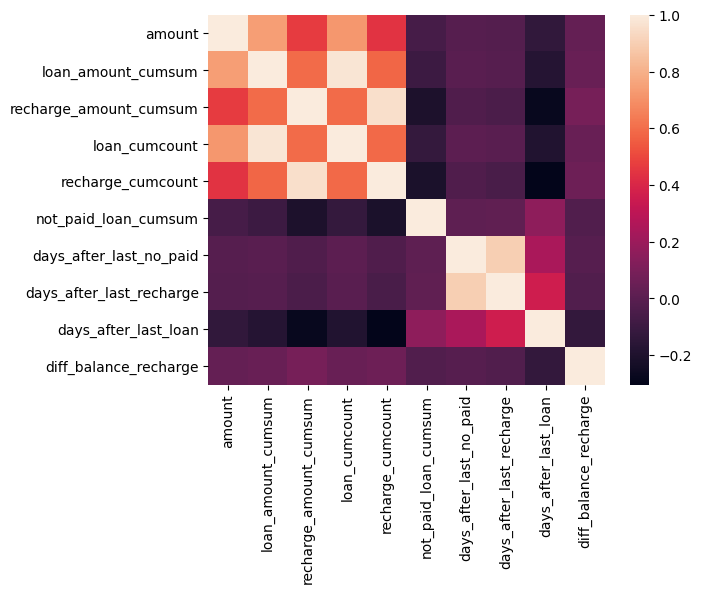

In [42]:
sns.heatmap(df_train[numeric_columns].corr())
plt.show()

In [43]:
Xy = pd.concat((df_train,y_train),axis=1)

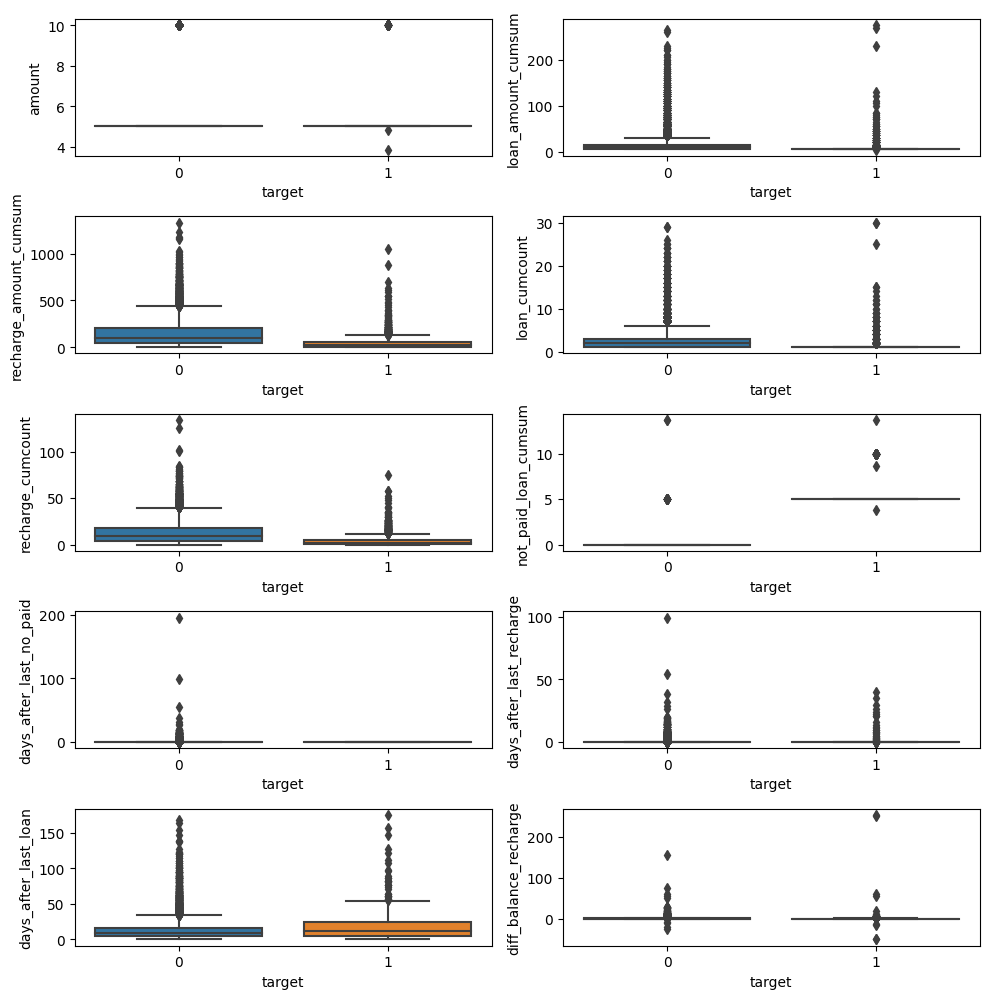

In [46]:
_,ax = plt.subplots(ncols=2,nrows = int(np.ceil(len(numeric_columns)/2)),figsize=(10,10))
ax= ax.flatten()

for i,nc in enumerate(numeric_columns):
    sns.boxplot(data = Xy, x = "target",y=nc, ax=ax[i])
plt.tight_layout()
plt.show()

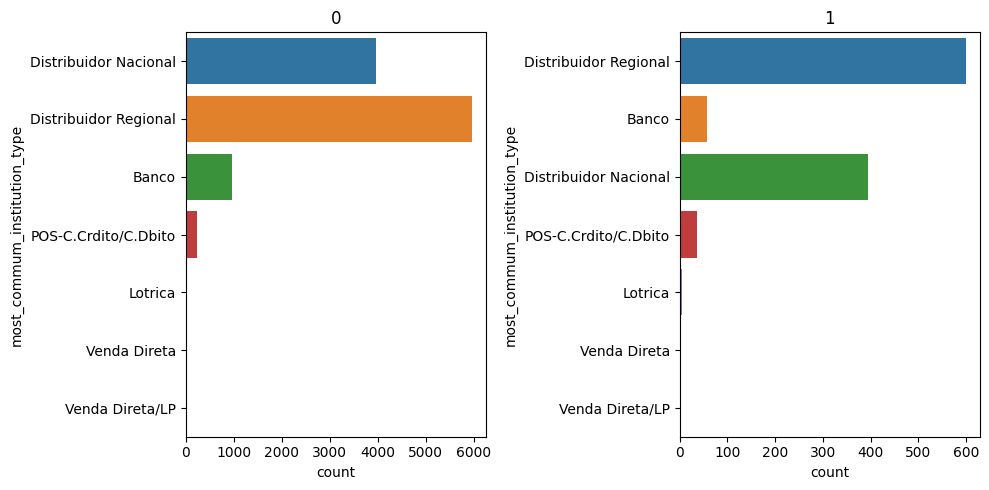

In [59]:
_,ax = plt.subplots(ncols=2,nrows=1,figsize = (10,5))

for t in [0,1]:
    sns.countplot(data = Xy[Xy.target == t],y = "most_commum_institution_type",ax=ax[t],orient="h")
    ax[t].set_title(t)
plt.tight_layout()
plt.show()

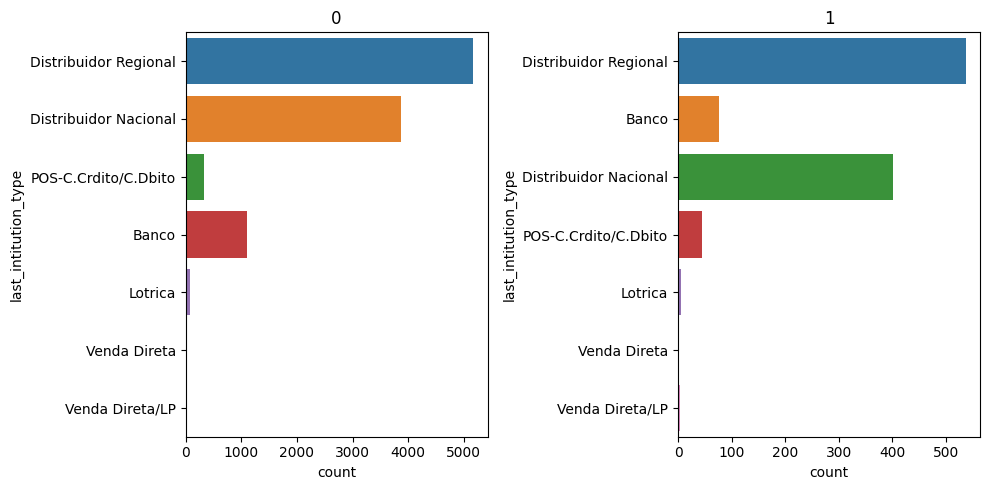

In [60]:
_,ax = plt.subplots(ncols=2,nrows=1,figsize = (10,5))

for t in [0,1]:
    sns.countplot(data = Xy[Xy.target == t],y = "last_intitution_type",ax=ax[t],orient="h")
    ax[t].set_title(t)
plt.tight_layout()
plt.show()

# Modelagem

In [64]:
classifier = xgb.XGBClassifier()

In [84]:
pd.DataFrame(ohe.transform(df_train[categorical_columns]),columns=ohe.get_feature_names_out())

,most_commum_institution_type_Banco,most_commum_institution_type_Distribuidor Nacional,most_commum_institution_type_Distribuidor Regional,most_commum_institution_type_Lotrica,most_commum_institution_type_POS-C.Crdito/C.Dbito,most_commum_institution_type_Venda Direta,most_commum_institution_type_Venda Direta/LP,most_commum_institution_type_nan,last_intitution_type_Banco,last_intitution_type_Distribuidor Nacional,last_intitution_type_Distribuidor Regional,last_intitution_type_Lotrica,last_intitution_type_POS-C.Crdito/C.Dbito,last_intitution_type_Venda Direta,last_intitution_type_Venda Direta/LP,last_intitution_type_nan
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13267,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13268,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13269,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13270,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [96]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit(df_train[categorical_columns])
df_train_ = pd.concat((df_train.drop(columns = categorical_columns).reset_index(drop=True),
                       pd.DataFrame(ohe.transform(df_train[categorical_columns]),columns=ohe.get_feature_names_out())),
                axis=1)

In [97]:
classifier = classifier.fit(df_train_,y_train)

In [98]:
confusion_matrix(y_train,classifier.predict(df_train_))

array([[11548,     0],
       [    0,  1724]], dtype=int64)

In [99]:
df_test_ = pd.concat((df_test.drop(columns = categorical_columns).reset_index(drop=True),
                       pd.DataFrame(ohe.transform(df_test[categorical_columns]),columns=ohe.get_feature_names_out())),
                axis=1)

In [101]:
confusion_matrix(y_test,classifier.predict(df_test_))

array([[4936,    0],
       [   0,  753]], dtype=int64)

In [104]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
df_train_.iloc[:,classifier.feature_importances_.argmax()]

0        0.125007
1        0.124995
2        0.124998
3        0.125004
4        0.125001
           ...   
13267    0.125002
13268    0.125001
13269    0.125002
13270    0.125002
13271    0.125005
Name: days_after_last_no_paid, Length: 13272, dtype: float64

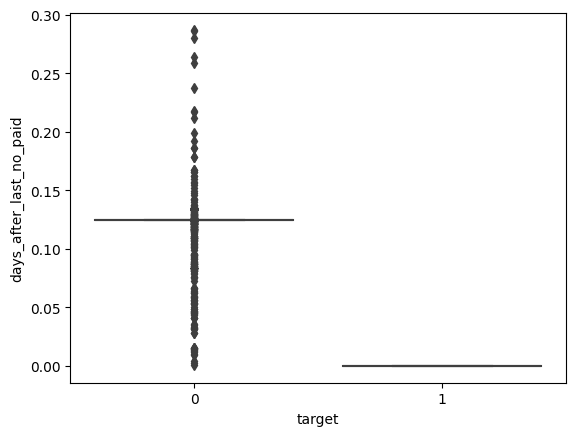

In [112]:
sns.boxplot(data = Xy.query("days_after_last_no_paid < 0.3"), x = "target",y="days_after_last_no_paid")
plt.show()